# Notes about simulation:

# Import packages and set settings

In [124]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools
from scipy.optimize import fsolve

In [127]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [125]:
# sns.palplot(sns.husl_palette(10, l=.7))
# palette_husl = sns.husl_palette(10, l=.7)
# sns.set_palette(palette_husl)
# # palette_husl.as_hex()
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()

In [126]:
MAPK_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#8ace88', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#005723'}
MAP2K_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}

MAPK_palette = {0:'#323232', 50:'#D3D3D3', 150:'#8ace88', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#005723'}
MAP2K_palette = {0:'#323232', 50:'#D3D3D3', 150:'#84bcdb', 250:'#5ab769', 350: '#319a50', 450:'#117b38', 550:'#084082'}


palettes = {0:MAPK_palette,
           1:MAP2K_palette,
           2:MAPK_palette,
           3:MAPK_palette,
           4:MAPK_palette }


# Supporting Functions

In [219]:
def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44                                 # volume of a yeast cell
    return molecules/(Na*cell_volume*10**-15)*1000000 # returns uM

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
#     new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = new_params[idx_top]

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses


    
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M, colors=None):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    if colors:
        pal3 = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]


## Function to plot param behaviors

In [128]:
def plt_param_behaviors(top_params, plt_top, params_constants, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
#             print(len(t100a_data))
#             if sig == 0:
#                 continue
#                 print(mapk_time_t100a_long)
#                 ax2.plot(mapk_time_t100a_long, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))
#             else:
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
#     print(params_constants[1])

    if param == 3:
        ax1.set_ylim(0,150)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

    if params_constants[-1] == 0:
        ax1.set_ylim(50,105)

    for sig in doses:
        for params in top_params[:plt_top]:
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_wt_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active, color=palette.get(sig))

#             if sig == 0: 
#                 time = np.linspace(0,300,3001)
#             else: 
#                 time = np.linspace(0,60,601)
            data = simulate_t100a_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
            ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    
def plt_ramp_behaviors(top_params, plt_top, params_constants, initials, gen, time, param, hog1_ramp_data=None, mapk_ramp_time=None):
    fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
    
    ax1.plot(mapk_ramp_time, hog1_ramp_data[0], 'o', color='gray')
    
    for params in top_params[:plt_top]:
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_ramp_experiment(ss_data, params_constants, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active)
    plt.show()


In [ ]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
#     if t_step >= 40:
#         sig = 600000
    return sig
plt.plot(time,[signal_ramp_special(x) for x in time])

## Function to plot param behaviors, diff consts

In [129]:
def plt_param_behaviors_consts_diff(top_params, plt_top, consts_diff, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

    if param == 3:
        ax1.set_ylim(0,150)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

#     if params_constants[-1] == 0:
#         ax1.set_ylim(50,105)

    for sig in doses:
        for params, params_constants in zip(top_params[:plt_top], consts_diff[:plt_top]):
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_wt_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active, color=palette.get(sig))

#             if sig == 0: 
#                 time = np.linspace(0,300,3001)
#             else: 
#                 time = np.linspace(0,60,601)
            data = simulate_t100a_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
            ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()

## Calculate score

In [214]:
def scorefxn(inits, total_protein, params, hog1=True, t100a=True, pbs2=True, pbs2_t100a=True, ramp=True, ptp23D=False):
    mses = []
    exp_time = mapk_time
#     params = convert_individual(learned_params, arr_conversion_matrix, number_of_params)
    
    wt_ss_inits = run_wt_ss(inits, total_protein, params) 
#     check = total_protein-wt_ss_inits
#     print(total_protein)
#     print(wt_ss_inits)
#     print(check)
#     if (check < 0).any():
#         print(wt_ss_inits*total_protein/100)
#         return ((63+69+18*2+27)*100)**2
    
    if ptp23D:
        ptpD_ss_inits = run_ss(inits, [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t*params[-1]], params)
        check = total_protein-ptpD_ss_inits
        if (check < 0).any():
            return ((63+69+18*2+27)*100)**2
            # for ptpDs
        mse_total = 0
        for dose, data in zip(ptp_doses, mapk_ptp_data):      
            odes = simulate_wt_experiment(ptpD_ss_inits, [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t*params[-1]], dose, params, exp_time)
            mapk = odes[:,2]/total_protein[2]*100
            error_active = ((data - mapk)**2).mean()
            mse_total += error_active

    # wt hog1
    if hog1:
        mse_total = 0
        for dose, data in zip(doses, mapk_wt_data): 
            odes = simulate_wt_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
            mapk = odes[:,2]/total_protein[2]*100
            error_active = ((data - mapk)**2).mean()
            mse_total += error_active
    #     mses.append(mse_total/63)
        mses.append(mse_total)
        
    # t100a hog1
    if t100a:
        mse_total = 0
        for dose, data in zip(doses, mapk_t100a_data):
            if dose == 0:
                odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, mapk_time_t100a_long)
                mapk = odes[:,2]/total_protein[2]*100
                error_active = ((mapk_data_t100a_long[0] - mapk)**2).mean()
                mse_total += error_active

            else:
                odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
                mapk = odes[:,2]/total_protein[2]*100
                error_active = ((data - mapk)**2).mean()
                mse_total += error_active
        mses.append(mse_total)

    
    # wt pbs2
    if pbs2:
        mse_total = 0
        for dose, data in zip(map2k_doses, map2k_wt_data): 
            odes = simulate_wt_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
            map2k = odes[:,1]/total_protein[1]*100
            error_active = ((data - map2k)**2).mean()
            mse_total += error_active
    #     mses.append(mse_total/18)
        mses.append(mse_total)
    
#     t100a pbs2
    if pbs2_t100a:
        mse_total = 0
        for dose, data in zip(map2k_doses, map2k_t100a_data):  
            odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
            map2k = odes[:,1]/total_protein[1]*100
            error_active = ((data - map2k)**2).mean()
            mse_total += error_active
    #     mses.append(mse_total/18)
        mses.append(mse_total)
    
    # ramp
    if ramp:
        mse_total = 0
        for data in hog1_ramp_data:   
            odes = simulate_ramp_experiment(wt_ss_inits, total_protein, params, mapk_ramp_time)
            mapk = odes[:,2]/total_protein[2]*100
            error_active = ((data - mapk)**2).mean()
            mse_total += error_active
    #     mses.append(mse_total/13)
        mses.append(mse_total)

    
#     mses.append(mse_total/27)
    mses.append(mse_total)
    
    return mses

# Load data to fit to

In [ ]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_data_t100a_long = [mapk_t100a_data[0]] 
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


# scorefxn_data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data]
# scorefxn_time = [mapk_time,mapk_ramp_time]

In [131]:
# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]


In [ ]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

# idx_closest_time_points = get_closest_tps(mapk_time,time)

# Mutual inhibition

##  190827_kb_M2.py

**Notes** 
- including basal activation for Hog1 with more simple model

### Inputs

In [210]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190827_kb_M2/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118+400)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_2', 'K_4', 'K_6' ] #21

minimums = [-4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4]

maximums = [ 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly']

In [133]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [209]:
run_wt_ss(initials, params_constants, top_params_M2[0]) 

array([1.31650198e+02, 1.15805336e-03, 2.82203744e-03, 3.74842403e+03])

In [204]:
def model(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(model, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #21
    learned_params = beta_3, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
#     if t_step >= 40:
#         sig = 600000
    return sig
# plt.plot(time,[signal_ramp_special(x) for x in time])

In [135]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(model, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [211]:
idx_top, top_params_M2, top, plt_top, new_params, params_from_file, mse_M2, last_mses_M2 = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2535.98945270705
Mean MSE of top 5%: 2654.534270252955


### Plot

In [218]:
for params in top_params_M2:
    x = scorefxn(initials, params_constants, params)
    print(x)
    if type(x) == list:
        print(sum(x[:2]))

[1360.8905130385856, 1175.0990563865212, 1247.6073498120156, 2455.6929643915955, 684.7462533031443, 684.7462533031443]
2535.9895694251068
[962.0916688867012, 2851.631948593867, 322.4630765416904, 2176.116048040264, 185.61965203306244, 185.61965203306244]
3813.7236174805685


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[1268.1819994094492, 1323.9454957376036, 1092.9824169799945, 2162.33921302599, 648.7517674899884, 648.7517674899884]
2592.1274951470527
[1077.146289468608, 1518.9406851422948, 577.3932367122552, 1294.7675120634317, 567.5085658688828, 567.5085658688828]
2596.086974610903
[1173.0771888825934, 1432.149555048652, 1269.913084238974, 3012.4315876118308, 653.4491633494453, 653.4491633494453]
2605.2267439312454
[1035.0420858023053, 1576.9447304304722, 1064.0764340839721, 2401.754862972384, 461.8473285341122, 461.8473285341122]
2611.9868162327775
[1269.0685976216178, 1356.0386430875617, 1399.1316360671399, 3506.26634538099, 693.9995431148443, 693.9995431148443]
2625.1072407091797
[1177.9749153844145, 3206.7087793771025, 880.9350821924021, 2280.7343318922863, 642.8172429206921, 642.8172429206921]
4384.6836947615175
[1035.3714088689885, 1619.8070479296066, 6162589149.848668, 93469327635.63644, 528.707488875705, 528.707488875705]
2655.178456798595
[1001.1621317047333, 1666.8753158421018, 914.17730

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


[1163.9538105575398, 1550.798349486825, 994.4669926457609, 1880.7283130757028, 834.6535516586666, 834.6535516586666]
2714.7521600443647
[1021.1388268269532, 2748.11790626517, 295.70845045197973, 1901.2126293195356, 695.2022096904639, 695.2022096904639]
3769.256733092123
[940.7418940870732, 1776.3582756313504, 1308.962690734559, 3598.932768178249, 482.1310464928401, 482.1310464928401]
2717.100169718424
[1142.1993658051356, 1575.1664294650238, 1036.7538187600885, 2528.2920313609156, 481.1132538132683, 481.1132538132683]
2717.3657952701597


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

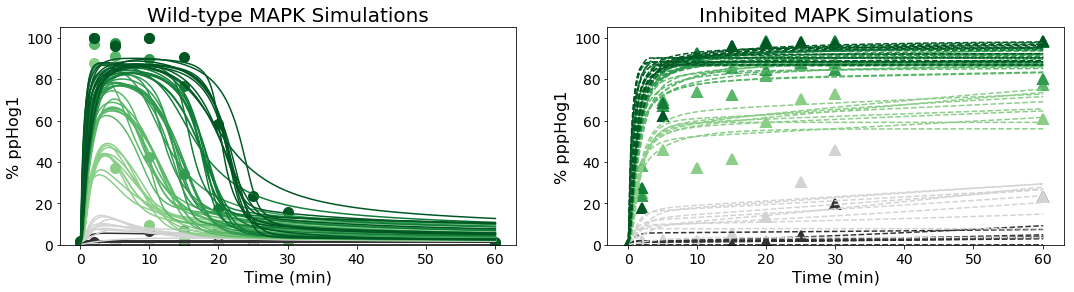

In [138]:
plt_param_behaviors(top_params_M2, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [60]:
# plt_param_behaviors(top_params_a1_1D, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

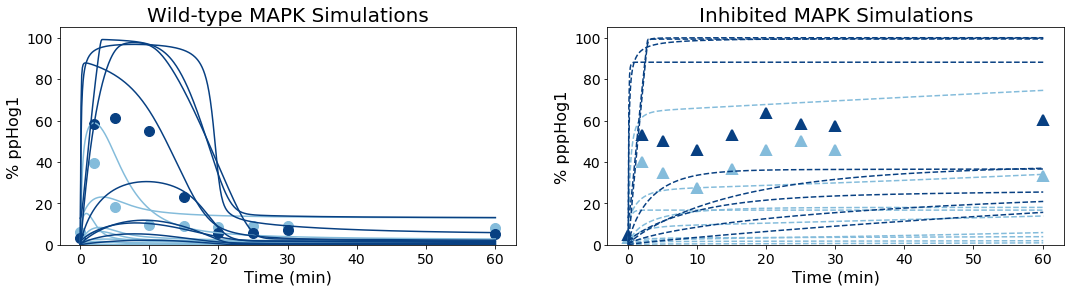

In [139]:
plt_param_behaviors(top_params_M2, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

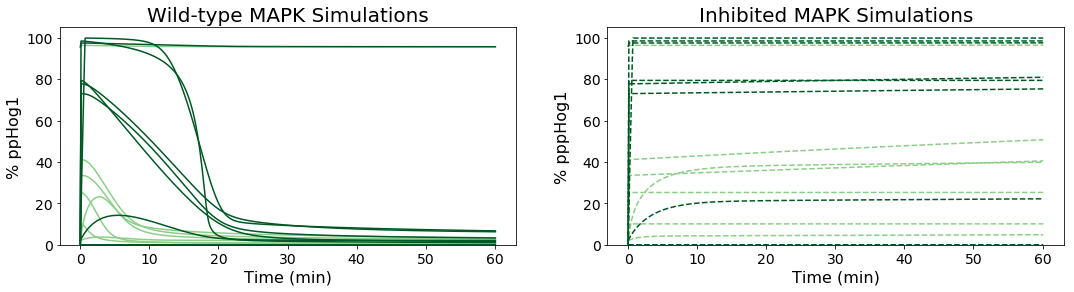

In [62]:
plt_param_behaviors(top_params_M2, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

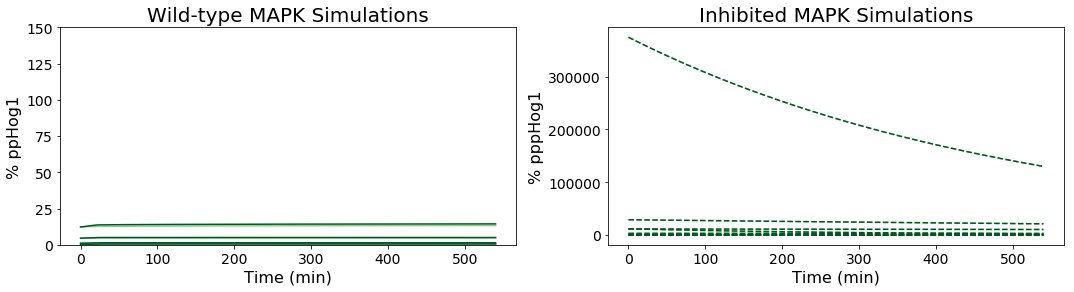

In [140]:
plt_param_behaviors(top_params_M2, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [ ]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


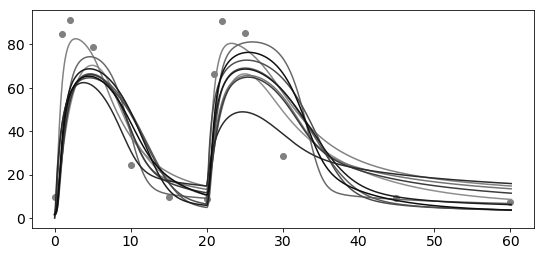

In [141]:
plt_ramp_behaviors(top_params_M2, 10, params_constants, initials, 5000, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

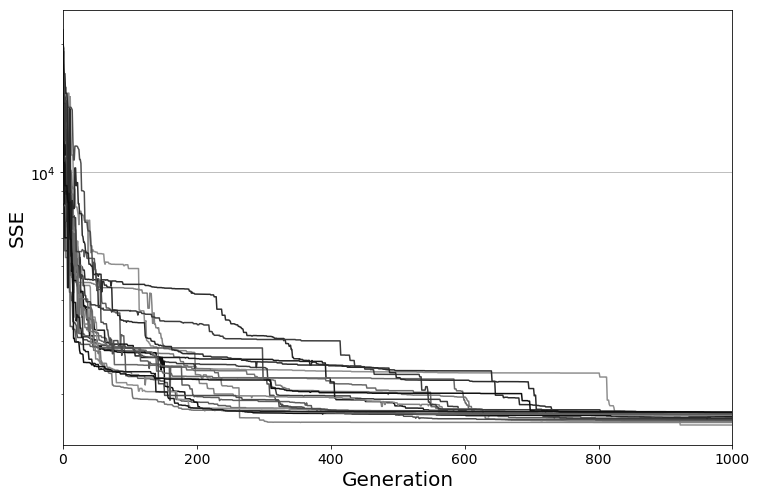

In [142]:
plt_mses_gen(gen,mse_M2)

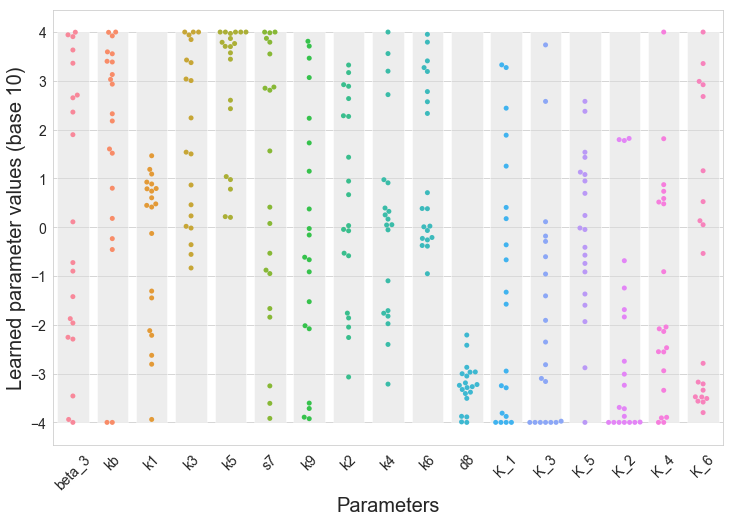

In [66]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c','#3c3c3c']*7 #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190827_kb_M2a.py

**Notes** 


### Inputs

In [143]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190827_kb_M2a/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118+400)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_2', 'K_4', 'K_6' ] #21

minimums = [-4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4]

maximums = [ 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly']

In [144]:
if len(labelnames) == len(diff):
    print('Params and labels match')
else:
    print(len(labelnames))
    print(len(diff))

Params and labels match


In [145]:
def model(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb + alpha_1*MAPK)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(model, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params 

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb + alpha_1*MAPK)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(ramp, inits, time, args=(total_protein, learned_params))
    return odes


def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
    return sig

### Gather simulated data

In [146]:
idx_top, top_params_M2a, top, plt_top, new_params, params_from_file, mse_M2a, last_mses_M2a = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2a)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2301.4864428111814
Mean MSE of top 5%: 2422.4994431716245


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

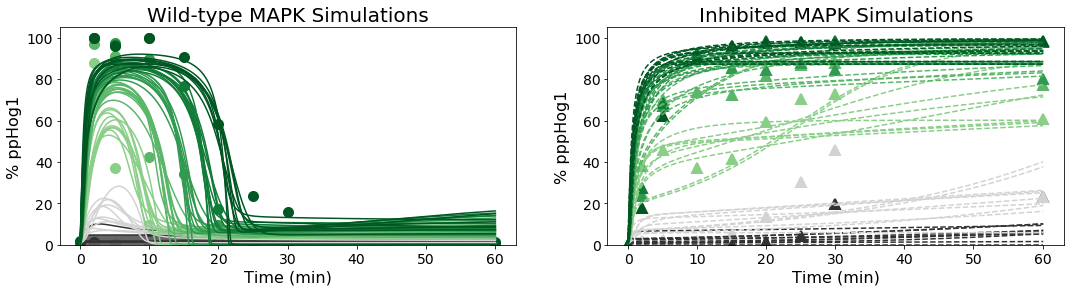

In [147]:
plt_param_behaviors(top_params_M2a, 10, params_constants, initials, gen, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [79]:
# plt_param_behaviors(top_params_M2a, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

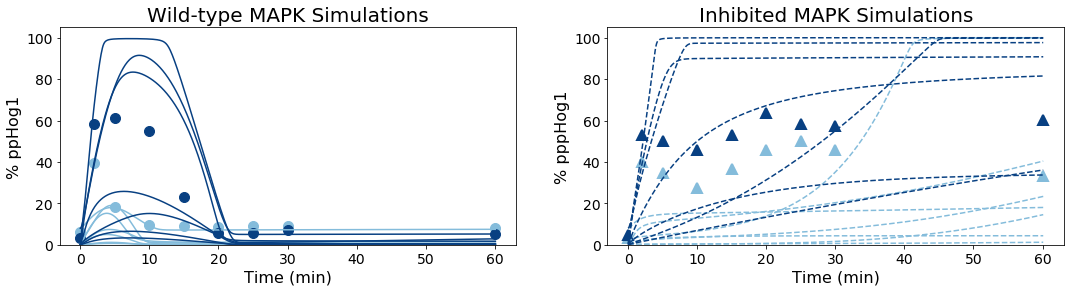

In [148]:
plt_param_behaviors(top_params_M2a, 10, params_constants, initials, gen, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

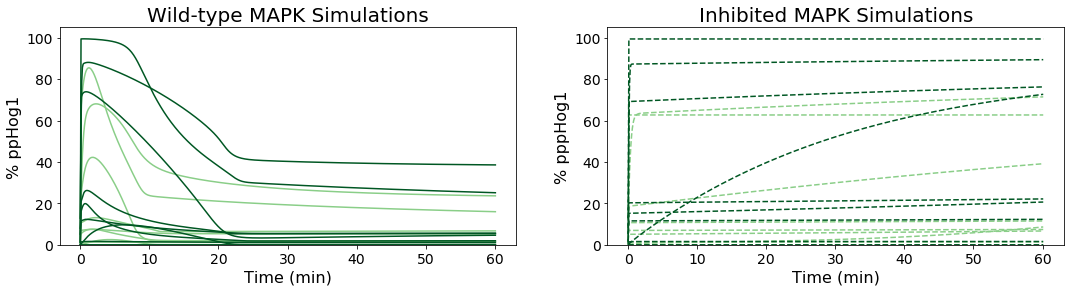

In [149]:
plt_param_behaviors(top_params_M2a, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

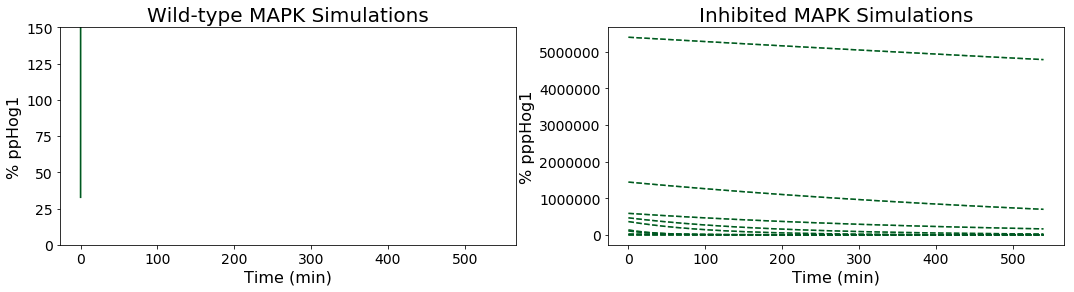

In [150]:
plt_param_behaviors(top_params_M2a, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [83]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


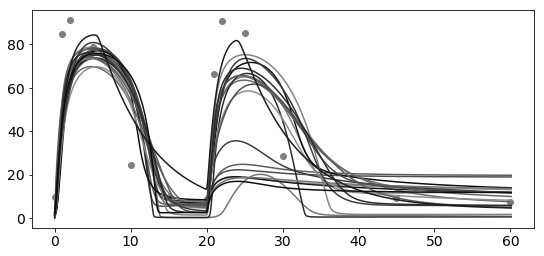

In [151]:
plt_ramp_behaviors(top_params_M2a, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

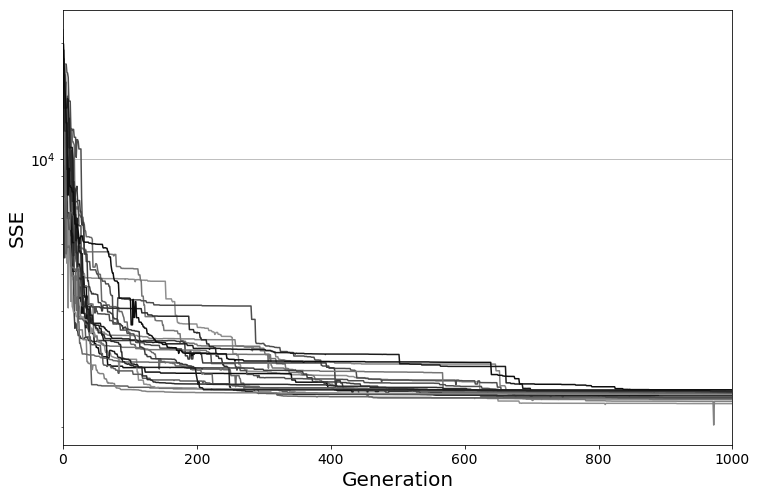

In [152]:
plt_mses_gen(gen,mse_M2a)

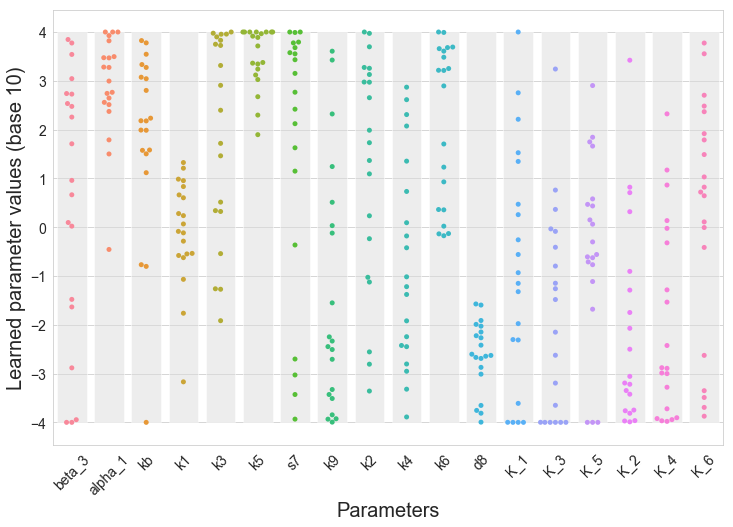

In [153]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190827_kb_M2b.py

**Notes** 


### Inputs

In [154]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190827_kb_M2b/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118+400)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_2', 'K_4', 'K_6' ] #21

minimums = [-4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4]

maximums = [ 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly']

In [155]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [156]:
def model(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb )/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = ((((k3+ alpha_1*MAPK)*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(model, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params 

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb )/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = ((((k3+ alpha_1*MAPK)*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(ramp, inits, time, args=(total_protein, learned_params))
    return odes


def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
    return sig

### Gather simulated data

In [157]:
idx_top, top_params_M2b, top, plt_top, new_params, params_from_file, mse_M2b, last_mses_M2b = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2b)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 786.5149865480081
Mean MSE of top 5%: 1004.9561204896443


### Plot

<Figure size 864x576 with 0 Axes>

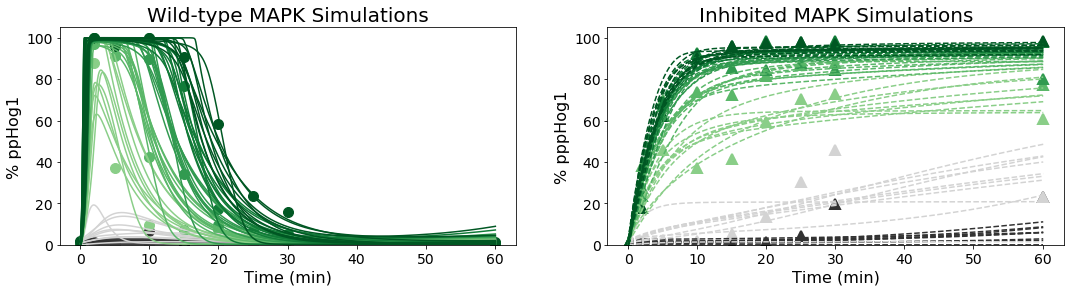

In [158]:
plt_param_behaviors(top_params_M2b, 10, params_constants, initials, gen, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [97]:
# plt_param_behaviors(top_params_M2b, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

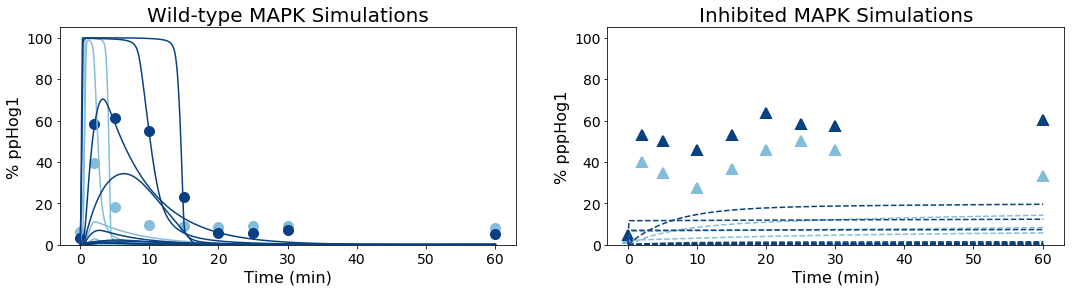

In [159]:
plt_param_behaviors(top_params_M2b, 10, params_constants, initials, gen, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

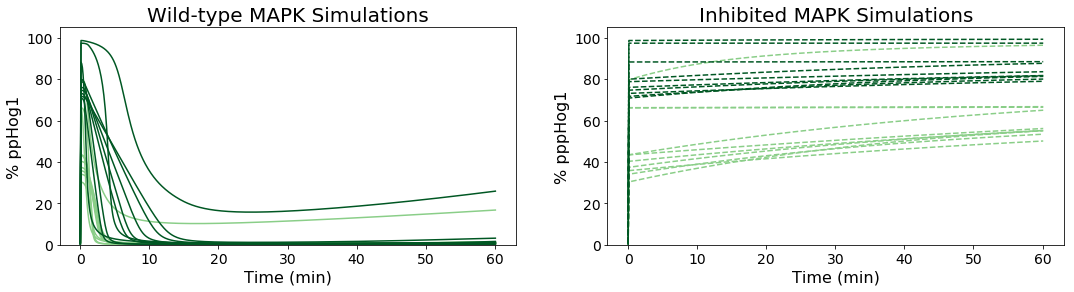

In [160]:
plt_param_behaviors(top_params_M2b, 10, params_constants, initials, 5000, map2k_doses, time, 0)

In [ ]:
plt_param_behaviors(top_params_M2b, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [102]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


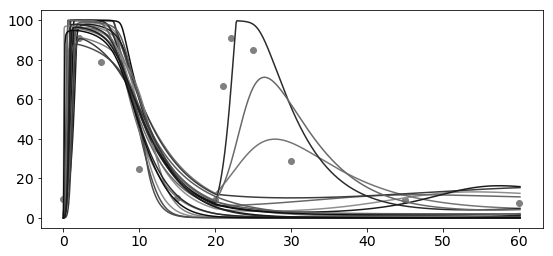

In [162]:
plt_ramp_behaviors(top_params_M2b, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

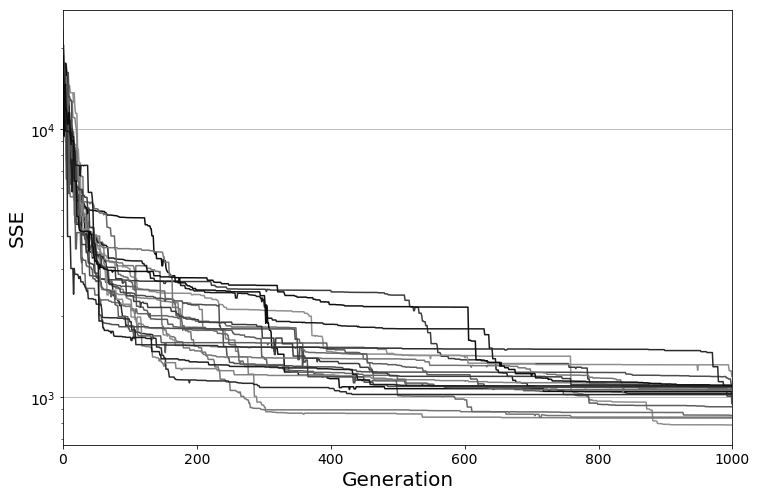

In [163]:
plt_mses_gen(gen,mse_M2b)

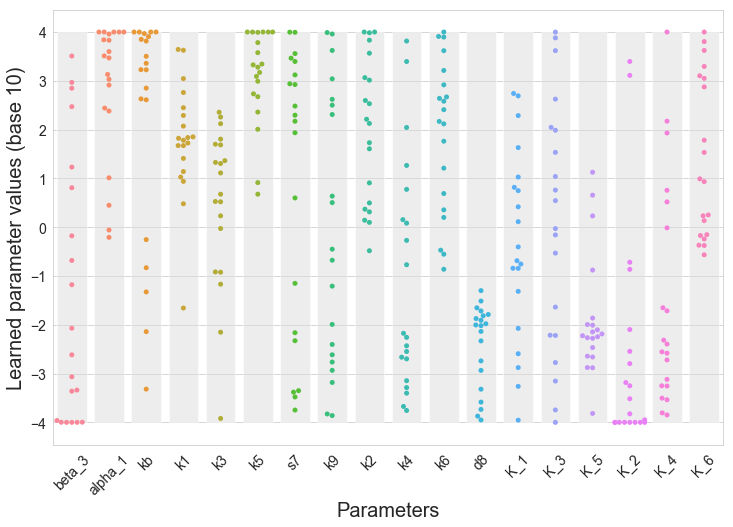

In [164]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190827_kb_M2c.py

**Notes** 


### Inputs

In [165]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190827_kb_M2c/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118+400)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_2', 'K_4', 'K_6' ] #21

minimums = [-4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4]

maximums = [ 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly']

In [106]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [166]:
def model(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb )/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = ((((k3)*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = ((((k5+ alpha_1*MAPK)*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(model, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(model, inits, time, args=(total_protein, sig, learned_params))
    return odes

def ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, alpha_1, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params 

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1 + kb )/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = ((((k3)*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = ((((k5+ alpha_1*MAPK)*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly

    return dMAP3K, dMAP2K, dMAPK, dgly


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(ramp, inits, time, args=(total_protein, learned_params))
    return odes


def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
    return sig

### Gather simulated data

In [167]:
idx_top, top_params_M2c, top, plt_top, new_params, params_from_file, mse_M2c, last_mses_M2c = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2c)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 842.8777380894583
Mean MSE of top 5%: 1085.0439610289354


### Plot

In [181]:
for params in top_params_M2c:
    x = scorefxn(initials, params_constants, params)
    print(x)
    if type(x) == list:
        print(sum(x))

[274.71447725243127, 568.163963443887, 1189.4130739827765, 2124.7292276062926, 1410.7839072430486, 1410.7839072430486]
6978.588556771485
[285.38978185605185, 641.3806312540694, 856.6287370484755, 1640.9927762668094, 366.56888723409065, 366.56888723409065]
4157.529700893588
380250000
[161.80725507962444, 816.0785903037081, 1317.4148810613374, 3376.451935860545, 193.20166271177, 193.20166271177]
6058.155987728755
[545.3487126252604, 499.6582969027039, 1459.647159739994, 4056.368688074865, 571.5499220011212, 571.5499220011212]
7704.122701345066
380250000
[461.93747450313936, 630.0892993498331, 1464.6816735471978, 4094.015826319236, 453.90320711987255, 453.90320711987255]
7558.530687959152
380250000
380250000
[615.6000476664403, 486.5109361305603, 825.1610604405591, 806.2023892112655, 830.8766532942329, 830.8766532942329]
4395.227740037291
380250000
380250000
380250000
380250000
380250000
[478.70127255429594, 677.6545294403525, 1382.5034168243483, 3461.020788402155, 1693.873646116572, 1693

<Figure size 864x576 with 0 Axes>

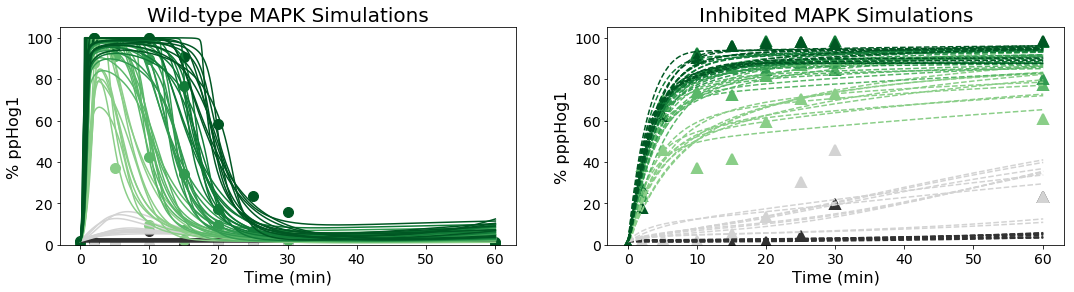

In [168]:
plt_param_behaviors(top_params_M2c, 10, params_constants, initials, gen, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [97]:
# plt_param_behaviors(top_params_M2c, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

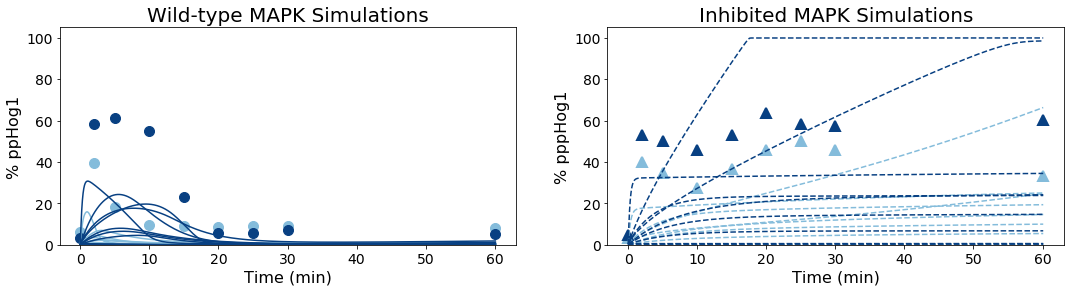

In [169]:
plt_param_behaviors(top_params_M2c, 10, params_constants, initials, gen, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

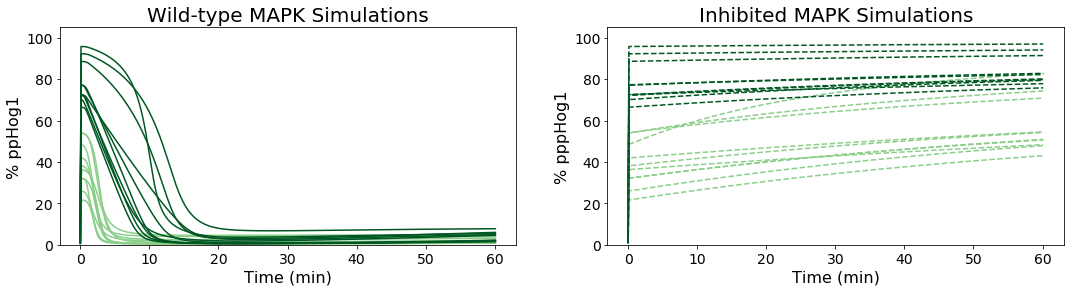

In [170]:
plt_param_behaviors(top_params_M2c, 10, params_constants, initials, 5000, map2k_doses, time, 0)

<Figure size 864x576 with 0 Axes>

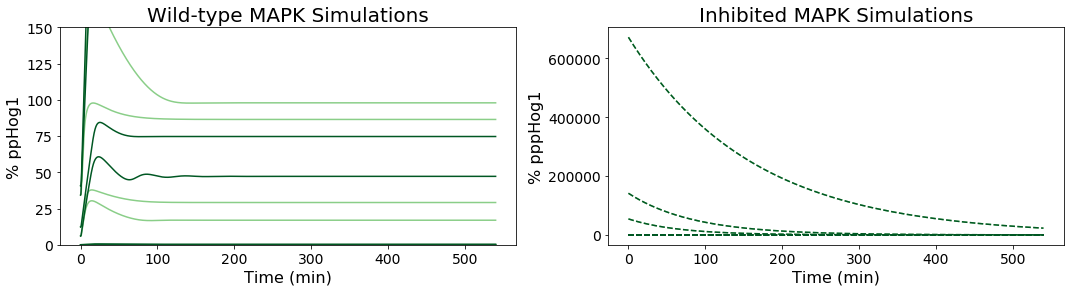

In [171]:
plt_param_behaviors(top_params_M2c, 10, params_constants, initials, 5000, map2k_doses, time, 3)

In [102]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

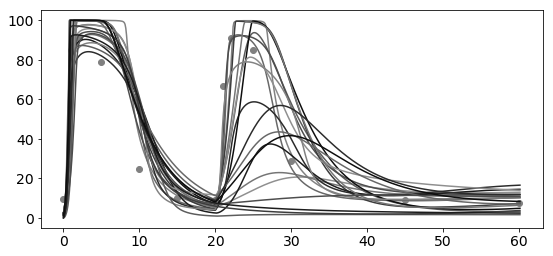

In [172]:
plt_ramp_behaviors(top_params_M2c, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

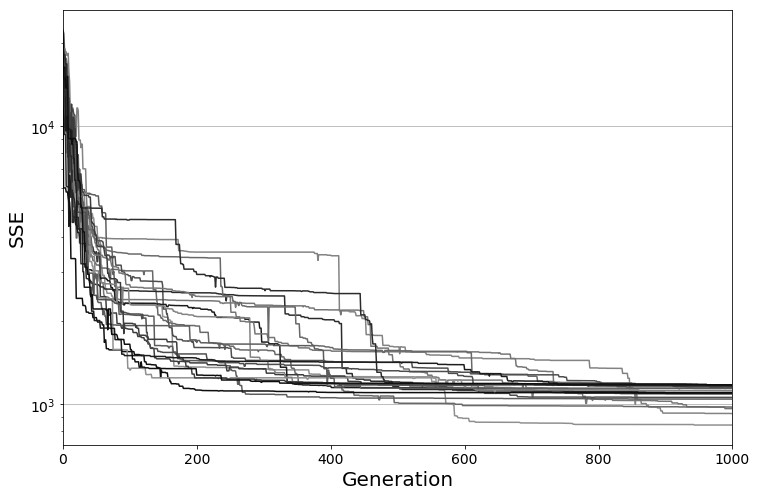

In [173]:
plt_mses_gen(gen,mse_M2c)

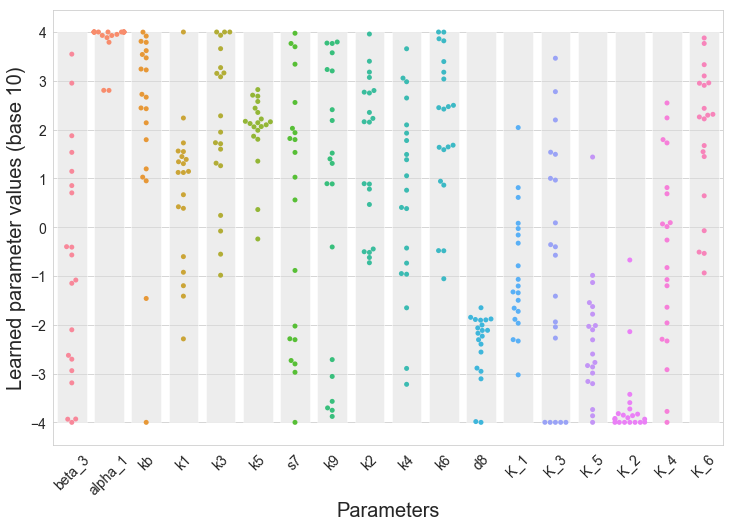

In [115]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

# Compare models

## Assess parameter space

In [158]:
best_fit = top_params_a1_1D[0].copy()
best_fit

[0.0006328370014249666,
 8411.94998094207,
 194969.3611864842,
 9083.122596160052,
 0.00020665934450005293,
 180.31191588674275,
 1168.9708060113849,
 0.00036961134050459733,
 2007.3309369545398,
 0.04492665564243325,
 0.19933738292603168,
 0.0008612421930380466,
 101.97930325211492,
 0.043138318696052516,
 0.0007374908022939019,
 3106.2884939909836,
 0.0018355452457365742,
 0.00010013699562135449,
 96.38453387916549,
 2846.1431872918183,
 0.99999999958208]

In [163]:
def change_param(param_set, idx):
    param_sets = []
#     print(param_set[idx])
    for i in np.logspace(-4,4,8):
        new_param_set = param_set.copy()
#         print(i)
#         print(new_param_set[idx])
        new_param_set[idx] = new_param_set[idx]*i
#         print(new_param_set[idx])
        param_sets.append(new_param_set)
    return param_sets

In [165]:
b3 = change_param(best_fit, 0)
a1 = change_param(best_fit, 1)
a2 = change_param(best_fit, 2)
kb = change_param(best_fit, 3)
k1 = change_param(best_fit, 4)
k3 = change_param(best_fit, 5)
k5 = change_param(best_fit, 6)
s7 = change_param(best_fit, 7)
k9 = change_param(best_fit, 8)
k2 = change_param(best_fit, 9)
k4 = change_param(best_fit, 10)
d8 = change_param(best_fit, 11)
K1 = change_param(best_fit, 12)
K3 = change_param(best_fit, 13)
K5 = change_param(best_fit, 14)
K9 = change_param(best_fit, 15)
K2 = change_param(best_fit, 16)
K4 = change_param(best_fit, 17)
K6 = change_param(best_fit, 18)
K10 = change_param(best_fit, 19)
pPTP= change_param(best_fit, 20)

<Figure size 864x576 with 0 Axes>

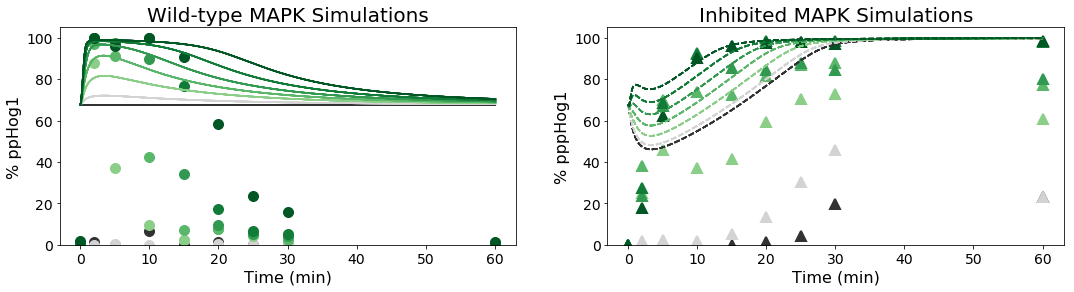

In [256]:
plt_param_behaviors(pPTP, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

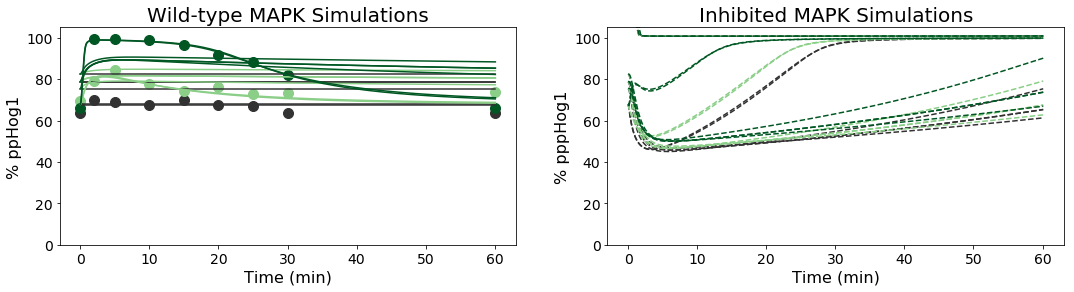

In [257]:
plt_param_behaviors_consts_diff(pPTP, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

## Calculate Ttest

In [39]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23, df_df_top_params_all, axis=0)
print(ttest)

Ttest_indResult(statistic=array([ 2.39679427, -2.79229073, -1.32267715,  1.35465514, -0.54118825,
        1.7618635 , -1.96711273, -0.65253951, -2.92496233, -1.32407551,
        1.11084685,  3.27659218, -2.54644332, -0.51225341, -0.5430844 ,
       -0.64036423, -0.88305972, -0.81891478, -0.58938274,  5.35936213,
       13.22090904]), pvalue=array([1.73831097e-02, 5.69868390e-03, 1.87328616e-01, 1.76929721e-01,
       5.88930435e-01, 7.94939813e-02, 5.04386338e-02, 5.14740687e-01,
       3.80914011e-03, 1.86864583e-01, 2.67857974e-01, 1.22241783e-03,
       1.15725799e-02, 6.08992243e-01, 5.87626541e-01, 5.22608326e-01,
       3.78176751e-01, 4.13729348e-01, 5.56214849e-01, 2.11972735e-07,
       1.08039792e-29]))


Tukey's test (honing in on two comparisons of the group) for ANOVA (summary statistic comparing all of the groups) correcting for multiple testing https://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/

## Calculate score

In [290]:
hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
pbs2_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]

for params in top_params_a1_1D[:10]:
    print(scorefxn(initials, params_constants, params))

[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.361472, 4.18506, 19.49207995, 23.08120093, 23.78618578, 22.3375094, 31.67199502, 36.30961501, 33.02963546, 34.87627365]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: operands could not be broadcast together with shapes (9,) (15,) 